In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
%config InlineBackend.figure_format = 'svg'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Environment 🌎

### MLflow is a useful tool to track experiment results

cd to the root directory of this lesson (in my case `/Users/paulabartabajo/src/online-courses/hands-on-rl/03_cart_pole`) and spin up the mlflow tracking server as follows:

**$ mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./artifacts --host 0.0.0.0 --port 5000**

### 💡 if you have another service listening to port 5000, increase port number by 1 until you hit a free port.

In [2]:
try:
    import mlflow
    print("mlflow already installed")
except ImportError:
    !python -m pip install -q mlflow
    print("Installed mlflow")

# connect mlflow client to the mlflow server that runs on localhost:5000
MLFLOW_SERVER_URI = 'http://localhost:5000'

mlflow.set_tracking_uri(str(MLFLOW_SERVER_URI))

print("connected")

EXPERIMENT_NAME = 'nn_hyperparameter_search'
mlflow.set_experiment(EXPERIMENT_NAME)
print("set")


mlflow already installed
connected


2022/06/21 17:37:40 INFO mlflow.tracking.fluent: Experiment with name 'nn_hyperparameter_search' does not exist. Creating a new experiment.


set


## Create an Optuna study

In [3]:
try:
    import optuna
    print("optuna already installed")
except ImportError:
    !python -m pip install -q optuna
    print("Installed optuna")

from src.config import OPTUNA_DB

study = optuna.create_study(
    study_name=EXPERIMENT_NAME,
    direction='maximize',
    load_if_exists=True,
    storage=f'sqlite:///{OPTUNA_DB}'
)

[I 2022-06-21 17:37:41,739] A new study created in RDB with name: nn_hyperparameter_search


optuna already installed


## Objective function we want to maximize

In [4]:
from src.optimize_hyperparameters import objective

# we define a lambda function because study.optimize()
# expect the objective function to have only 1 input
# (trial), while our objective function hast 2 extra
# inputs I defined to add flexibility to the script

from mlagents_envs.environment import UnityEnvironment
env_name = "TouchCube"
    
try:
    env.close()
except:
    pass

env = UnityEnvironment(file_name=env_name, no_graphics=True)
func = lambda trial: objective(trial,
                               force_linear_model=False,
                               n_episodes_to_train=100, 
                               env=env)

[INFO] Connected to Unity environment with package version 1.2.0-preview and communication version 1.0.0


INFO:mlagents_envs.environment:Connected to Unity environment with package version 1.2.0-preview and communication version 1.0.0


## Set threshold to terminate hyperparameter search

In [7]:
class CheckHyperparamMeanRewardThreshold:
    def __init__(self, reward_threshold: float):
        self.reward_threshold = reward_threshold

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial) -> None:
        if trial.value >= self.reward_threshold:
            print((f'Stopping hyperparameter search because trial.value ({trial.value}) '
                   f'hit threshold ({self.reward_threshold})'))
            study.stop()

# Stop hyperparameter search when we hit a perfect mean reward of mean_reward_to_stop
mean_reward_to_stop = 10
hyperparam_search_stop_callback = CheckHyperparamMeanRewardThreshold(mean_reward_to_stop)

## Let's start the search

In [11]:
study.optimize(func, n_trials=50, callbacks=[hyperparam_search_stop_callback])

num agents  1
action size  3
state size  21
Agent state looks like: 
[[-0.6468659   0.         -0.08219272 -0.6468659  -0.83987963 -0.08219272
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: nn_layers =  4  nn_hidden_layers =  64


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:295: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, self.nn_hidden_layers, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:296: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts 

epoch 100 success rate 0.75 ep_mean_r -139.30 exploration 0.92          

[I 2022-06-21 18:00:41,916] Trial 5 finished with value: -187.02149999999997 and parameters: {'nn_layers': 4, 'nn_hidden_layers': 64}. Best is trial 5 with value: -187.02149999999997.


mlflow loop, mean_reward =  -187.02149999999997 std_reward =  74.73736925226898
num agents  1
action size  3
state size  21
Agent state looks like: 
[[ 0.43353194  0.          0.4605973   0.43353194 -0.83987963  0.4605973
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: nn_layers =  3  nn_hidden_layers =  256


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:295: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, self.nn_hidden_layers, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:296: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts 

epoch 100 success rate 0.75 ep_mean_r -155.60 exploration 0.93          

[I 2022-06-21 18:27:21,641] Trial 6 finished with value: -180.22899999999998 and parameters: {'nn_layers': 3, 'nn_hidden_layers': 256}. Best is trial 6 with value: -180.22899999999998.


mlflow loop, mean_reward =  -180.22899999999998 std_reward =  63.415041662053646
num agents  1
action size  3
state size  21
Agent state looks like: 
[[ 0.16286129  0.          0.39190966  0.16286129 -0.83987963  0.39190966
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: nn_layers =  4  nn_hidden_layers =  256


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:295: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, self.nn_hidden_layers, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:296: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts 

epoch 100 success rate 0.00 ep_mean_r -500.00 exploration 0.42          

[I 2022-06-21 19:15:13,419] Trial 7 finished with value: -487.033 and parameters: {'nn_layers': 4, 'nn_hidden_layers': 256}. Best is trial 6 with value: -180.22899999999998.


mlflow loop, mean_reward =  -487.033 std_reward =  18.418273833342795
num agents  1
action size  3
state size  21
Agent state looks like: 
[[ 0.03070322  0.          0.4928604   0.03070322 -0.83987963  0.4928604
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: nn_layers =  3  nn_hidden_layers =  64


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:295: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, self.nn_hidden_layers, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:296: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts 

epoch 100 success rate 0.65 ep_mean_r -225.00 exploration 0.92          

[I 2022-06-21 19:30:49,344] Trial 8 finished with value: -186.335 and parameters: {'nn_layers': 3, 'nn_hidden_layers': 64}. Best is trial 6 with value: -180.22899999999998.


mlflow loop, mean_reward =  -186.335 std_reward =  66.28212937889064
num agents  1
action size  3
state size  21
Agent state looks like: 
[[-0.68649     0.         -0.00369326 -0.68649    -0.83987963 -0.00369326
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: nn_layers =  2  nn_hidden_layers =  256


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:295: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, self.nn_hidden_layers, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:296: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts 

epoch 100 success rate 0.70 ep_mean_r -171.95 exploration 0.96          

[I 2022-06-21 19:46:34,703] Trial 9 finished with value: -172.68850000000003 and parameters: {'nn_layers': 2, 'nn_hidden_layers': 256}. Best is trial 9 with value: -172.68850000000003.


mlflow loop, mean_reward =  -172.68850000000003 std_reward =  64.81774635661132
num agents  1
action size  3
state size  21
Agent state looks like: 
[[ 0.51964253  0.          0.14307529  0.51964253 -0.83987963  0.14307529
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: nn_layers =  2  nn_hidden_layers =  64


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:295: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, self.nn_hidden_layers, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:296: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts 

epoch 100 success rate 0.55 ep_mean_r -237.95 exploration 0.95          

[I 2022-06-21 20:01:03,296] Trial 10 finished with value: -174.1685 and parameters: {'nn_layers': 2, 'nn_hidden_layers': 64}. Best is trial 9 with value: -172.68850000000003.


mlflow loop, mean_reward =  -174.1685 std_reward =  72.58761521602703
num agents  1
action size  3
state size  21
Agent state looks like: 
[[ 0.52823406  0.         -0.23912393  0.52823406 -0.83987963 -0.23912393
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: nn_layers =  2  nn_hidden_layers =  256


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:295: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, self.nn_hidden_layers, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:296: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts 

epoch 100 success rate 0.90 ep_mean_r -64.60 exploration 0.95          

[I 2022-06-21 20:17:17,916] Trial 11 finished with value: -175.7735 and parameters: {'nn_layers': 2, 'nn_hidden_layers': 256}. Best is trial 9 with value: -172.68850000000003.


mlflow loop, mean_reward =  -175.7735 std_reward =  59.61101930641683
num agents  1
action size  3
state size  21
Agent state looks like: 
[[ 0.21436797  0.         -0.6587282   0.21436797 -0.83987963 -0.6587282
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: nn_layers =  3  nn_hidden_layers =  64


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:295: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, self.nn_hidden_layers, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:296: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts 

epoch 100 success rate 0.65 ep_mean_r -187.95 exploration 0.94          

[I 2022-06-21 20:32:09,238] Trial 12 finished with value: -177.51700000000005 and parameters: {'nn_layers': 3, 'nn_hidden_layers': 64}. Best is trial 9 with value: -172.68850000000003.


mlflow loop, mean_reward =  -177.51700000000005 std_reward =  62.0162789999529
num agents  1
action size  3
state size  21
Agent state looks like: 
[[-0.61336464  0.         -0.23597248 -0.61336464 -0.83987963 -0.23597248
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: nn_layers =  4  nn_hidden_layers =  64


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:295: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, self.nn_hidden_layers, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:296: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts 

epoch 100 success rate 0.65 ep_mean_r -220.75 exploration 0.90          

[I 2022-06-21 20:48:14,765] Trial 13 finished with value: -190.399 and parameters: {'nn_layers': 4, 'nn_hidden_layers': 64}. Best is trial 9 with value: -172.68850000000003.


mlflow loop, mean_reward =  -190.399 std_reward =  54.45723045657022
num agents  1
action size  3
state size  21
Agent state looks like: 
[[ 0.4947216   0.         -0.04471072  0.4947216  -0.83987963 -0.04471072
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: nn_layers =  3  nn_hidden_layers =  64


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:295: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, self.nn_hidden_layers, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:296: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts 

epoch 100 success rate 0.70 ep_mean_r -173.25 exploration 0.92          

[I 2022-06-21 21:04:19,604] Trial 14 finished with value: -182.86500000000004 and parameters: {'nn_layers': 3, 'nn_hidden_layers': 64}. Best is trial 9 with value: -172.68850000000003.


mlflow loop, mean_reward =  -182.86500000000004 std_reward =  66.08457100564398
num agents  1
action size  3
state size  21
Agent state looks like: 
[[-0.183151    0.          0.4346331  -0.183151   -0.83987963  0.4346331
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: nn_layers =  2  nn_hidden_layers =  256


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:295: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, self.nn_hidden_layers, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:296: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts 

epoch 100 success rate 0.85 ep_mean_r -106.60 exploration 0.94          

[I 2022-06-21 21:21:30,529] Trial 15 finished with value: -179.34349999999998 and parameters: {'nn_layers': 2, 'nn_hidden_layers': 256}. Best is trial 9 with value: -172.68850000000003.


mlflow loop, mean_reward =  -179.34349999999998 std_reward =  67.58239365951756
num agents  1
action size  3
state size  21
Agent state looks like: 
[[-0.3889411   0.         -0.5025153  -0.3889411  -0.83987963 -0.5025153
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: nn_layers =  2  nn_hidden_layers =  256


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:295: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, self.nn_hidden_layers, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:296: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts 

epoch 100 success rate 0.60 ep_mean_r -251.55 exploration 0.97          

[I 2022-06-21 21:36:49,646] Trial 16 finished with value: -167.49649999999997 and parameters: {'nn_layers': 2, 'nn_hidden_layers': 256}. Best is trial 16 with value: -167.49649999999997.


mlflow loop, mean_reward =  -167.49649999999997 std_reward =  61.25042336792457
num agents  1
action size  3
state size  21
Agent state looks like: 
[[-0.20910387  0.          0.65980834 -0.20910387 -0.83987963  0.65980834
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: nn_layers =  2  nn_hidden_layers =  256


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:295: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, self.nn_hidden_layers, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:296: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts 

epoch 100 success rate 0.50 ep_mean_r -262.70 exploration 0.96          

[I 2022-06-21 21:52:42,150] Trial 17 finished with value: -171.727 and parameters: {'nn_layers': 2, 'nn_hidden_layers': 256}. Best is trial 16 with value: -167.49649999999997.


mlflow loop, mean_reward =  -171.727 std_reward =  66.78369726961813
num agents  1
action size  3
state size  21
Agent state looks like: 
[[ 0.07939275  0.          0.62275374  0.07939275 -0.83987963  0.62275374
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: nn_layers =  2  nn_hidden_layers =  256


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:295: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, self.nn_hidden_layers, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:296: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts 

epoch 100 success rate 0.65 ep_mean_r -203.30 exploration 0.97          

[I 2022-06-21 22:08:17,032] Trial 18 finished with value: -166.1965 and parameters: {'nn_layers': 2, 'nn_hidden_layers': 256}. Best is trial 18 with value: -166.1965.


mlflow loop, mean_reward =  -166.1965 std_reward =  58.742653266174486
num agents  1
action size  3
state size  21
Agent state looks like: 
[[ 0.12736298  0.          0.5164517   0.12736298 -0.83987963  0.5164517
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: nn_layers =  2  nn_hidden_layers =  256


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:295: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, self.nn_hidden_layers, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:296: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts 

epoch 100 success rate 0.60 ep_mean_r -225.35 exploration 0.90          

[I 2022-06-21 22:25:39,518] Trial 19 finished with value: -192.07049999999998 and parameters: {'nn_layers': 2, 'nn_hidden_layers': 256}. Best is trial 18 with value: -166.1965.


mlflow loop, mean_reward =  -192.07049999999998 std_reward =  68.38941222696683
num agents  1
action size  3
state size  21
Agent state looks like: 
[[-0.39816576  0.          0.05030564 -0.39816576 -0.83987963  0.05030564
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: nn_layers =  2  nn_hidden_layers =  256


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:295: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, self.nn_hidden_layers, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:296: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts 

epoch 100 success rate 0.65 ep_mean_r -194.45 exploration 0.96          

[I 2022-06-21 22:41:27,304] Trial 20 finished with value: -171.67350000000002 and parameters: {'nn_layers': 2, 'nn_hidden_layers': 256}. Best is trial 18 with value: -166.1965.


mlflow loop, mean_reward =  -171.67350000000002 std_reward =  60.792406374069444
num agents  1
action size  3
state size  21
Agent state looks like: 
[[-0.34954616  0.         -0.57347023 -0.34954616 -0.83987963 -0.57347023
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: nn_layers =  2  nn_hidden_layers =  256


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:295: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, self.nn_hidden_layers, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:296: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts 

epoch 100 success rate 0.75 ep_mean_r -174.50 exploration 0.94          

[I 2022-06-21 22:57:49,311] Trial 21 finished with value: -177.71950000000004 and parameters: {'nn_layers': 2, 'nn_hidden_layers': 256}. Best is trial 18 with value: -166.1965.


mlflow loop, mean_reward =  -177.71950000000004 std_reward =  72.0151869035275
num agents  1
action size  3
state size  21
Agent state looks like: 
[[-0.62240976  0.         -0.08814162 -0.62240976 -0.83987963 -0.08814162
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: nn_layers =  2  nn_hidden_layers =  256


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:295: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, self.nn_hidden_layers, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:296: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts 

epoch 100 success rate 0.70 ep_mean_r -161.10 exploration 0.97          

[I 2022-06-21 23:13:35,104] Trial 22 finished with value: -169.37599999999998 and parameters: {'nn_layers': 2, 'nn_hidden_layers': 256}. Best is trial 18 with value: -166.1965.


mlflow loop, mean_reward =  -169.37599999999998 std_reward =  63.57339438790412
num agents  1
action size  3
state size  21
Agent state looks like: 
[[-0.11170374  0.          0.6712829  -0.11170374 -0.83987963  0.6712829
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: nn_layers =  2  nn_hidden_layers =  256


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:295: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, self.nn_hidden_layers, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:296: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts 

epoch 100 success rate 0.70 ep_mean_r -197.45 exploration 0.96          

[I 2022-06-21 23:29:11,940] Trial 23 finished with value: -172.4995 and parameters: {'nn_layers': 2, 'nn_hidden_layers': 256}. Best is trial 18 with value: -166.1965.


mlflow loop, mean_reward =  -172.4995 std_reward =  60.03619803710091
num agents  1
action size  3
state size  21
Agent state looks like: 
[[ 0.646936    0.          0.15553452  0.646936   -0.83987963  0.15553452
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: nn_layers =  4  nn_hidden_layers =  256


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:295: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, self.nn_hidden_layers, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:296: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts 

epoch 100 success rate 0.55 ep_mean_r -271.25 exploration 0.92          

[I 2022-06-21 23:48:30,636] Trial 24 finished with value: -184.37 and parameters: {'nn_layers': 4, 'nn_hidden_layers': 256}. Best is trial 18 with value: -166.1965.


mlflow loop, mean_reward =  -184.37 std_reward =  64.0484820272893
num agents  1
action size  3
state size  21
Agent state looks like: 
[[ 0.25389308  0.         -0.6013607   0.25389308 -0.83987963 -0.6013607
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: nn_layers =  2  nn_hidden_layers =  256


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:295: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, self.nn_hidden_layers, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:296: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts 

epoch 100 success rate 0.75 ep_mean_r -149.35 exploration 0.96          

[I 2022-06-22 00:04:15,234] Trial 25 finished with value: -172.26699999999997 and parameters: {'nn_layers': 2, 'nn_hidden_layers': 256}. Best is trial 18 with value: -166.1965.


mlflow loop, mean_reward =  -172.26699999999997 std_reward =  54.74763338264039
num agents  1
action size  3
state size  21
Agent state looks like: 
[[-0.4874387   0.          0.12572308 -0.4874387  -0.83987963  0.12572308
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: nn_layers =  2  nn_hidden_layers =  256


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:295: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, self.nn_hidden_layers, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:296: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts 

epoch 100 success rate 0.50 ep_mean_r -260.00 exploration 0.96          

[I 2022-06-22 00:20:29,102] Trial 26 finished with value: -175.0535 and parameters: {'nn_layers': 2, 'nn_hidden_layers': 256}. Best is trial 18 with value: -166.1965.


mlflow loop, mean_reward =  -175.0535 std_reward =  60.174473514522745
num agents  1
action size  3
state size  21
Agent state looks like: 
[[ 0.42739797  0.          0.14729851  0.42739797 -0.83987963  0.14729851
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: nn_layers =  2  nn_hidden_layers =  256


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:295: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, self.nn_hidden_layers, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:296: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts 

epoch 100 success rate 0.80 ep_mean_r -143.25 exploration 0.96          

[I 2022-06-22 00:36:25,811] Trial 27 finished with value: -171.3575 and parameters: {'nn_layers': 2, 'nn_hidden_layers': 256}. Best is trial 18 with value: -166.1965.


mlflow loop, mean_reward =  -171.3575 std_reward =  64.87853973965505
num agents  1
action size  3
state size  21
Agent state looks like: 
[[ 0.43637496  0.          0.27707902  0.43637496 -0.83987963  0.27707902
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: nn_layers =  2  nn_hidden_layers =  256


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:295: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, self.nn_hidden_layers, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:296: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts 

epoch 100 success rate 0.85 ep_mean_r -116.95 exploration 0.95          

[I 2022-06-22 00:53:49,285] Trial 28 finished with value: -173.55700000000004 and parameters: {'nn_layers': 2, 'nn_hidden_layers': 256}. Best is trial 18 with value: -166.1965.


mlflow loop, mean_reward =  -173.55700000000004 std_reward =  64.46773651215001
num agents  1
action size  3
state size  21
Agent state looks like: 
[[-0.6730528   0.          0.04166793 -0.6730528  -0.83987963  0.04166793
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: nn_layers =  2  nn_hidden_layers =  256


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:295: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, self.nn_hidden_layers, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:296: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts 

epoch 100 success rate 0.80 ep_mean_r -134.80 exploration 0.95          

[I 2022-06-22 01:10:14,345] Trial 29 finished with value: -172.949 and parameters: {'nn_layers': 2, 'nn_hidden_layers': 256}. Best is trial 18 with value: -166.1965.


mlflow loop, mean_reward =  -172.949 std_reward =  60.92508349604455
num agents  1
action size  3
state size  21
Agent state looks like: 
[[ 0.12548643  0.          0.48562792  0.12548643 -0.83987963  0.48562792
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: nn_layers =  2  nn_hidden_layers =  256


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:295: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, self.nn_hidden_layers, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:296: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts 

epoch 13 success rate 0.50 ep_mean_r -287.30 exploration 3.86          

KeyboardInterrupt: 

## These are the best hyper-parameters

In [7]:
best_trial = study.best_trial

hparams = {k: best_trial.params[k] for k in best_trial.params if k != 'seed'}
#hparams['nn_hidden_layers'] = eval(hparams['nn_hidden_layers']) 
print(hparams)

#SEED = best_trial.params['seed']
#print('Seed: ', SEED)

{'actor_learning_rate': 0.0003355646816262674}


## We can re-run the training to get the perfect agent

In [11]:
from src.utils import set_seed
set_seed(env, SEED)

from src.q_agent import QAgent
agent = QAgent(env, **hparams)

from src.loops import train
train(agent, env, n_episodes=200)

67,586 parameters


100%|█████████████████████████████████████████████████████████████████████| 200/200 [00:13<00:00, 15.12it/s]

Reward mean: 337.64, std: 29.49
Num steps mean: 337.64, std: 29.49


## or simply load the `agent_id` from the best run

In [3]:
from src.q_agent import QAgent
from src.config import SAVED_AGENTS_DIR

# you can find the agent_id for the best run in the MLflow
# dashboard.
# 298 is the value in my case, but you need to check what is your
agent_id = 298

path_to_saved_model = SAVED_AGENTS_DIR / 'CartPole-v1' / str(agent_id)
agent = QAgent.load_from_disk(env, path_to_saved_model)

67,586 parameters


## Evaluate the agent ⏱️

In [4]:
from src.loops import evaluate
rewards, steps = evaluate(
    agent, env,
    n_episodes=1000,
    epsilon=0.00
)

100%|███████████████████████████████████████████████████████████████████| 1000/1000 [03:00<00:00,  5.54it/s]


In [5]:
import numpy as np
reward_avg = np.array(rewards).mean()
reward_std = np.array(rewards).std()
print(f'Reward average {reward_avg:.2f}, std {reward_std:.2f}')

Reward average 500.00, std 0.00


## Let's see how far we got in each attempt

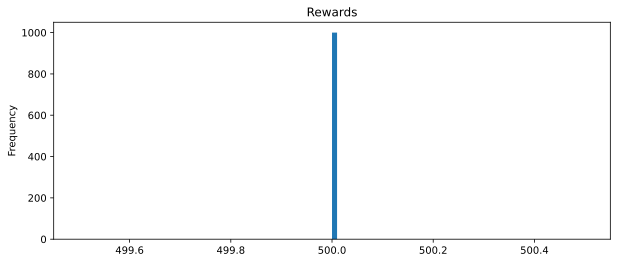

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(figsize = (10, 4))
ax.set_title("Rewards")    
pd.Series(rewards).plot(kind='hist', bins=100)

plt.show()

## Let's see our agent in action 🎬

In [49]:
# Workaround for pygame error: "error: No available video device"
# See https://stackoverflow.com/questions/15933493/pygame-error-no-available-video-device?rq=1
# This is probably needed only for Linux
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

from src.viz import show_video

show_video(agent, env, sleep_sec=0.01, seed=123)